# Spectral models in Gammapy

## Introduction

This notebook explains how to use the functions and classes in [gammapy.spectrum.models](http://docs.gammapy.org/en/latest/spectrum/#module-gammapy.spectrum.models) in order to work with spectral models.

The following clases will be used:

* [gammapy.spectrum.models.PowerLaw](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.PowerLaw.html)
* [gammapy.utils.modelling.Parameter](http://docs.gammapy.org/en/latest/api/gammapy.utils.modeling.Parameter.html)
* [gammapy.utils.modelling.ParameterList](docs.gammapy.org/en/latest/api/gammapy.utils.modeling.ParameterList.html)
* [gammapy.spectrum.models.SpectralModel](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.models.SpectralModel.html)

Feedback welcome!

## Setup

Same procedure as in every script ...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import numpy as np
import astropy.units as u
from gammapy.spectrum import models
from gammapy.utils.modeling import Parameter, ParameterList

## Initializing a model
Each model is initialized with parameters given as Quantity objects. There are no default values for the parameters, so you need to pass all of them on initialization.

In [3]:
index = 2.3 * u.Unit('')
amplitude = 1e-12 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV

pwl = models.PowerLaw(index=index, amplitude=amplitude, reference=reference)
print(pwl)

PowerLaw

Parameters: 

	   name     value   error       unit      min  max  frozen
	--------- --------- ----- --------------- ---- ---- ------
	    index 2.300e+00   nan                    0 None  False
	amplitude 1.000e-12   nan 1 / (cm2 s TeV)    0 None  False
	reference 1.000e+00   nan             TeV None None   True


As you see, some of the parameters have default ``min`` and ``values`` as well as a ``frozen`` flag. This is only relevant in the context of spectral fitting and thus covered in [spectrum_analysis.ipynb](https://github.com/gammapy/gammapy-extra/blob/master/notebooks/spectrum_analysis.ipynb). Also, the parameter errors are not set. This will be covered later in this tutorial

## Editing model parameters
The model parameters are stored as ``ParameterList`` on the spectal model. Each model parameter is ``Parameter`` instance. It has a ``value`` and a ``unit`` attribute, as well as a ``quantity`` property for convenience.

In [4]:
print(pwl.parameters)

print(pwl.parameters['index'])
pwl.parameters['index'].value=2.6
print(pwl.parameters['index'])

print(pwl.parameters['amplitude'])
pwl.parameters['amplitude'].quantity = 2e-12 * u.Unit('m-2 TeV-1 s-1')
print(pwl.parameters['amplitude'])

ParameterList
Parameter(name='index', value=2.3, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=1e-12, unit=Unit("1 / (cm2 s TeV)"), min=0, max=None, frozen=False)
Parameter(name='reference', value=1.0, unit=Unit("TeV"), min=None, max=None, frozen=True)

Covariance: 
None
Parameter(name='index', value=2.3, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='index', value=2.6, unit=Unit(dimensionless), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=1e-12, unit=Unit("1 / (cm2 s TeV)"), min=0, max=None, frozen=False)
Parameter(name='amplitude', value=2e-12, unit=Unit("1 / (m2 s TeV)"), min=0, max=None, frozen=False)


## Available models

All spectral models in gammapy are subclasses of ``SpectralModel``. The list of available models is shown below.

In [5]:
models.SpectralModel.__subclasses__()

[gammapy.spectrum.crab.MeyerCrabModel,
 gammapy.spectrum.models.PowerLaw2,
 gammapy.spectrum.models.AbsorbedSpectralModel,
 gammapy.spectrum.models.ExponentialCutoffPowerLaw3FGL,
 gammapy.spectrum.models.LogParabola,
 gammapy.spectrum.models.ExponentialCutoffPowerLaw,
 gammapy.spectrum.models.PowerLaw,
 gammapy.spectrum.models.TableModel,
 gammapy.spectrum.models.PLSuperExpCutoff3FGL]

## Plotting

In order to plot a model you can use the ``plot`` function. It expects an energy range as argument. You can also chose flux and energy units as well as an energy power for the plot

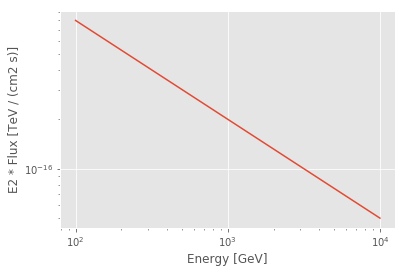

In [6]:
energy_range = [0.1, 10] * u.TeV
pwl.plot(energy_range, energy_power=2, energy_unit='GeV')

## Parameter errors

Parameters are stored internally as covariance matrix. There are, however, convenience methods to set individual parameter errors on ``ParameterList``.

In [7]:
errors = dict(
    index = 0.2 * u.Unit(''),
    amplitude = 0.1 * pwl.parameters['amplitude'].quantity
)
pwl.parameters.set_parameter_errors(errors)
print(pwl)

PowerLaw

Parameters: 

	   name     value     error        unit      min  max  frozen
	--------- --------- --------- -------------- ---- ---- ------
	    index 2.600e+00 2.000e-01                   0 None  False
	amplitude 2.000e-12 2.000e-13 1 / (m2 s TeV)    0 None  False
	reference 1.000e+00 0.000e+00            TeV None None   True

Covariance: 

	name/name index amplitude
	--------- ----- ---------
	    index  0.04       0.0
	amplitude   0.0     4e-26


You can plot the butterfly using the ``plot_error`` method.

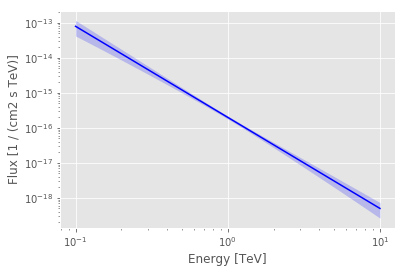

In [8]:
ax = pwl.plot_error(energy_range, color='blue', alpha=0.2)
pwl.plot(energy_range, ax=ax, color='blue')

## Integration

You've probably asked yourself already, if it's possible to integrated models. Yes, it is. Where analytical solutions are available, these are used by default. Otherwise, a numerical integration is performed.

In [9]:
integral = pwl.integral(emin=1 * u.TeV, emax= 10*u.TeV)
print(integral)

1.2186014196061302e-12 1 / (m2 s)


## Defining a custom model

Now we'll see how you can define a custom model. To do that you need to subclass ``SpectralModel``. As an example we will use a PowerLaw plus a Gaussian (with fixed width).

In [10]:
class UserModel(models.SpectralModel):
    def __init__(self, index, amplitude, reference, mean, width):
        self.parameters = ParameterList([
                Parameter('index', index, parmin=0),
                Parameter('amplitude', amplitude, parmin=0),
                Parameter('reference', reference, frozen=True),
                Parameter('mean', mean, parmin=0),
                Parameter('width', width, parmin=0, frozen=True)
            ])
    def evaluate(self, energy, index, amplitude, reference, mean, width):
        pwl = models.PowerLaw.evaluate(energy=energy, index=index, amplitude=amplitude, reference=reference)
        gauss = amplitude * np.exp(-1 *(energy - mean) ** 2/( 2 * width ** 2))
        return pwl + gauss

In [11]:
index = 2 * u.Unit('')
amplitude = 1e-12 * u.Unit('cm-2 s-1 TeV-1')
reference = 1 * u.TeV
mean = 5 * u.TeV
width = 0.2 * u.TeV

model = UserModel(index=index,
                  amplitude=amplitude,
                  reference=reference,
                  mean=mean,
                  width=width)
print(model)

UserModel

Parameters: 

	   name     value   error       unit      min  max  frozen
	--------- --------- ----- --------------- ---- ---- ------
	    index 2.000e+00   nan                    0 None  False
	amplitude 1.000e-12   nan 1 / (cm2 s TeV)    0 None  False
	reference 1.000e+00   nan             TeV None None   True
	     mean 5.000e+00   nan             TeV    0 None  False
	    width 2.000e-01   nan             TeV    0 None   True


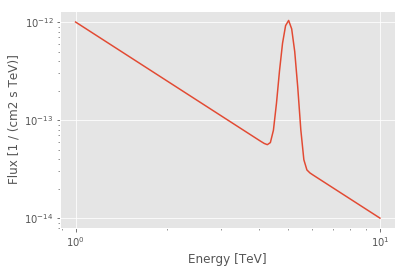

In [12]:
energy_range = [1, 10] * u.TeV

fig, ax = plt.subplots(1)
model.plot(ax=ax, energy_range=energy_range)

## What's next

In this tutorial we learnd how to work with spectral models. Go to [gammapy.spectrum](http://docs.gammapy.org/en/latest/spectrum/index.html) to see what else you can do with gammapy.spectrum.